# Creating A Training Set From s2p data


## Import pyMez and pyMez.Code.Analysis.SParameter  

In [1]:
import os
from pyMez import *
from pyMez.Code.Analysis.SParameter import *
from pyMez.Code.DataHandlers.NISTModels import *
from pyMez.Code.DataHandlers.Translations import *
import sys
sys.path.insert(0, '..')
#from Machine_Learning import *
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


Importing pyMez, this should take roughly 30 seconds
Importing Code.DataHandlers.GeneralModels
It took 5.133 s to import Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.HTMLModels
It took 0.939 s to import Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.NISTModels
It took 16.559 s to import Code.DataHandlers.NISTModels
Importing Code.DataHandlers.TouchstoneModels
It took 0.011 s to import Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
It took 0.377 s to import Code.DataHandlers.XMLModels
Importing Code.DataHandlers.ZipModels
It took 0.038 s to import Code.DataHandlers.ZipModels
Importing Code.InstrumentControl.Experiments
It took 3.252 s to import Code.InstrumentControl.Experiments
Importing Code.InstrumentControl.Instruments
It took 0.169 s to import Code.InstrumentControl.Instruments
Importing Code.Utils.Names
It took 0.015 s to import Code.Utils.Names
It took 26.494 s to import all of the active modules


## Define the files to be imported

In [3]:
device_type_dictionary={0:"Thru",1:"Short",2:"Load",3:"Thru Pos 7",4:"Thru Pos 9",
                        5:"Open"}
pretrain_folder=r"C:\Share\Scattering Parameter ML Training Set\PretrainFolder"


pretrain_folders=os.listdir(pretrain_folder)
pretrain_folders=map(lambda x:os.path.join(pretrain_folder,x),pretrain_folders)


In [4]:
def create_s2p_training_set(pretrain_folder,number_training_sets=1000,expansion_factor=1.0):
    """Given a directory containing multiple measurements this creates a list of np.arrays to 
    train a classifier"""
    pretrain_files=os.listdir(pretrain_folder)
    pretrain_files=map(lambda x:os.path.join(pretrain_folder,x),pretrain_files)
    # now open the files convert them to AsciiData Tables and find the mean and standard deviation
    first_file=Snp_to_AsciiDataTable(SNP(pretrain_files[0]))
    joined_file=first_file.copy()
    for file_name in pretrain_files[1:]:
        joined_file=joined_file+Snp_to_AsciiDataTable(SNP(file_name))
    mean_file=frequency_model_collapse_multiple_measurements(joined_file)
    std_file=frequency_model_collapse_multiple_measurements(joined_file,method="std")
    mean_array=AsciiDataTable_to_NumpyArray(mean_file,exclude_columns="Frequency")
    std_array=AsciiDataTable_to_NumpyArray(std_file,exclude_columns="Frequency")
    
    training_arrays=np.array([np.random.normal(loc=mean_value,scale=expansion_factor*std_array[index]+.0001,
                                               size=number_training_sets) for index,
                              mean_value in enumerate(mean_array)])

    training_arrays=[[training_arrays[i][j] 
                      for i in range(len(mean_array))] for j in range(number_training_sets)]
    return training_arrays





In [5]:
pretrain_folders

['C:\\Share\\Scattering Parameter ML Training Set\\PretrainFolder\\Load',
 'C:\\Share\\Scattering Parameter ML Training Set\\PretrainFolder\\Open',
 'C:\\Share\\Scattering Parameter ML Training Set\\PretrainFolder\\Short',
 'C:\\Share\\Scattering Parameter ML Training Set\\PretrainFolder\\Thru',
 'C:\\Share\\Scattering Parameter ML Training Set\\PretrainFolder\\Thru Pos 7',
 'C:\\Share\\Scattering Parameter ML Training Set\\PretrainFolder\\Thru Pos 9']

In [6]:
number_training_sets=1000
expansion_factor=1
sorted_device_keys=sorted(device_type_dictionary.keys())
training_array=[]
for key in sorted_device_keys:
    training_array=training_array+create_s2p_training_set(os.path.join(pretrain_folder,
                                                               "{0}".format(device_type_dictionary[key])),
                                                  number_training_sets,expansion_factor=2.0)
target_array=[]
for key_index,key in enumerate(sorted_device_keys):
    target_array=target_array+[key for i in range(number_training_sets)]


In [7]:
len(target_array)

6000

In [8]:
classifier=QuadraticDiscriminantAnalysis()
classifier.fit(training_array,target_array)


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

In [9]:
test_folder=r"C:\Share\Scattering Parameter ML Training Set\Test Set 1"
test_files=os.listdir(test_folder)
test_files=map(lambda x:os.path.join(test_folder,x),test_files)

In [10]:
len(test_files)

24

In [11]:
test_array=[]
for file_name in test_files:
    test_array=test_array+[AsciiDataTable_to_NumpyArray(Snp_to_AsciiDataTable(SNP(file_name)),exclude_columns="Frequency")]
predictions=classifier.predict(test_array)
file_name_predictions={test_files[index]:device_type_dictionary[key] for index,key in enumerate(predictions.tolist())}

In [12]:
for key,value in file_name_predictions.iteritems():
    print("{0} is type {1}".format(os.path.basename(key),value))

Load_Connect3.s2p is type Load
Thru_POS_7_Connect_2_T_20190201.s2p is type Thru
Load_Connect1.s2p is type Load
Thru_Connect2.s2p is type Thru Pos 9
open_connect1.s2p is type Open
Thru_POS_7_Connect_2_U_20190201.s2p is type Thru Pos 7
Thru_POS_7_Connect_1_U_20190201.s2p is type Thru Pos 7
Thru_POS_7_Connect_3_U_20190201.s2p is type Thru Pos 7
Thru_Connect1.s2p is type Thru
Thru_POS_9_Connect_3_T_20190201.s2p is type Thru
Thru_POS_7_Connect_1_T_20190201.s2p is type Thru
Thru_POS_7_Connect_3_T_20190201.s2p is type Thru
open_connect3.s2p is type Open
short_connect3.s2p is type Short
open_connect2.s2p is type Open
Thru_POS_9_Connect_3_U_20190201.s2p is type Thru Pos 9
Thru_POS_9_Connect_2_U_20190201.s2p is type Thru Pos 9
short_connect1.s2p is type Short
Thru_Connect3.s2p is type Thru Pos 9
Thru_POS_9_Connect_2_T_20190201.s2p is type Thru
Thru_POS_9_Connect_1_T_20190201.s2p is type Thru
short_connect2.s2p is type Short
Thru_POS_9_Connect_1_U_20190201.s2p is type Thru Pos 9
Load_Connect2.s2p

In [12]:
predictions

array([1, 7, 7, 7, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 4, 4, 4, 5, 5, 5,
       2, 2, 2, 1, 1, 1, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0])

In [81]:
device_key=0
print("There are {0} of {1}".format(predictions.tolist().count(device_key),device_type_dictionary[device_key]))

There are 7 of Thru


In [12]:
test_file_s2p_list=[S2PV1(file_name) for file_name in test_files]

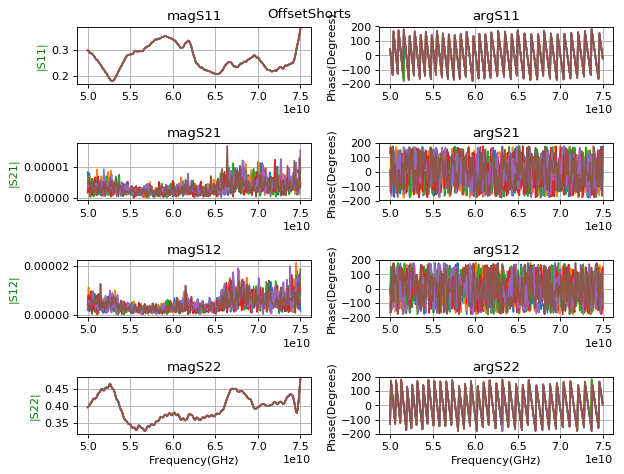

In [68]:
%matplotlib inline
device_key=3
device_list=[]
for index,prediction in enumerate(predictions.tolist()):
    if prediction==device_key:
        device_list.append(test_file_s2p_list[index])
    
title=device_type_dictionary[device_key]
compare_s2p_plots(device_list,display_legend=False,title=title,format="MA");


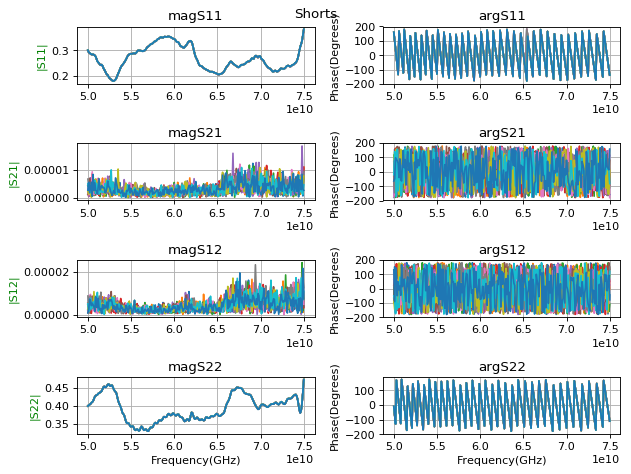

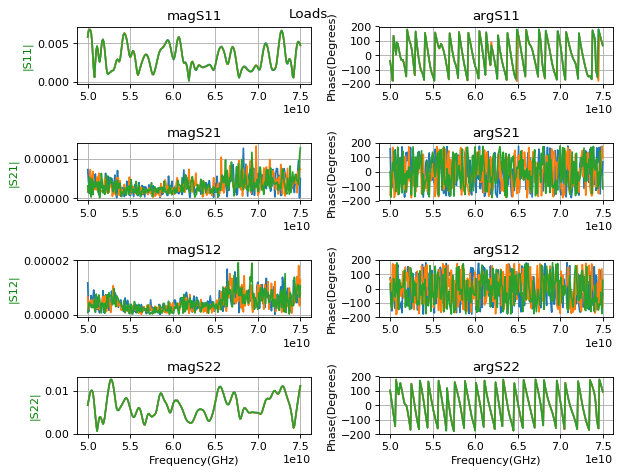

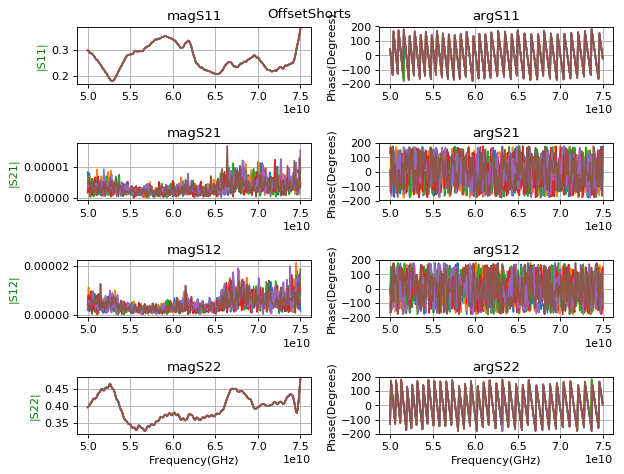

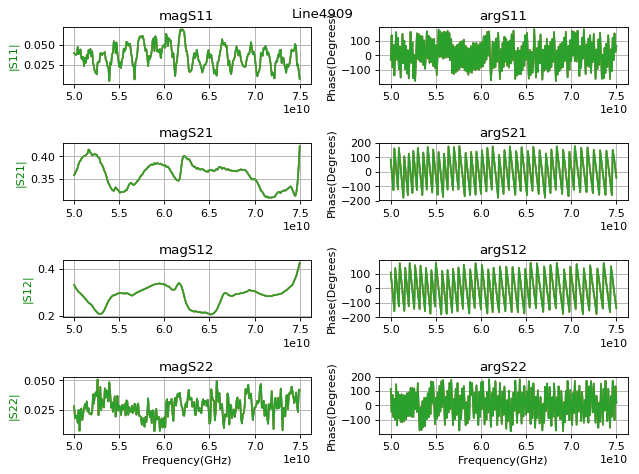

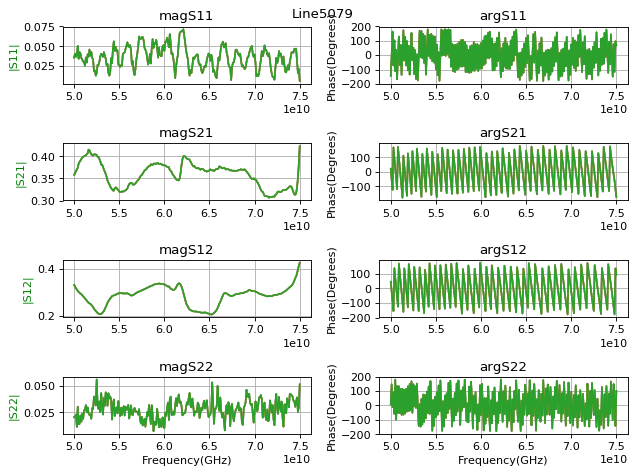

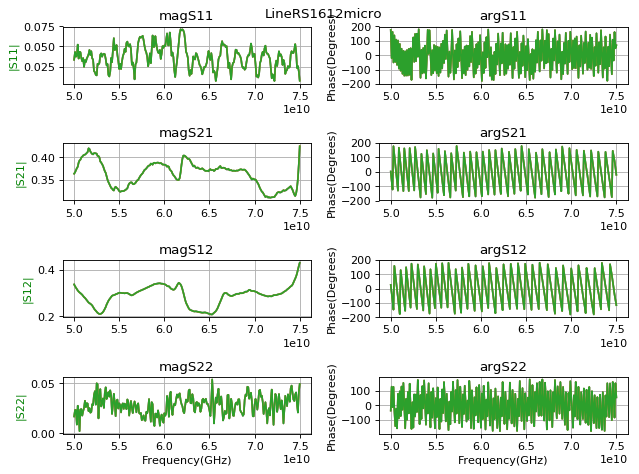

In [14]:
for device_key in range(1,7):
    device_list=[]
    for index,prediction in enumerate(predictions.tolist()):
        if prediction==device_key:
            device_list.append(test_file_s2p_list[index])

    title=device_type_dictionary[device_key]
    compare_s2p_plots(device_list,display_legend=False,title=title,format="MA");

In [108]:
test_folder=r"C:\Share\WaveParameter Machine Learning\Dazhen Test Files"
test_files=os.listdir(test_folder)
test_files=map(lambda x:os.path.join(test_folder,x),test_files)
test_array=[]
for file_name in test_files:
    test_array=test_array+[AsciiDataTable_to_NumpyArray(Snp_to_AsciiDataTable(SNP(file_name)),exclude_columns="Frequency")]
predictions=classifier.predict(test_array)
file_name_predictions={test_files[index]:device_type_dictionary[key] for index,key in enumerate(predictions.tolist())}
for key,value in file_name_predictions.iteritems():
    print("{0} is type {1}".format(os.path.basename(key),value))

WR15_reflect.s2p is type Line5079
WR15_line1_4p909.s2p is type LineRS1612micro
HP_Shim.s2p is type Atten3DB
WR15_thru.s2p is type Line5079
WR15_line2_5p079.s2p is type Line4909


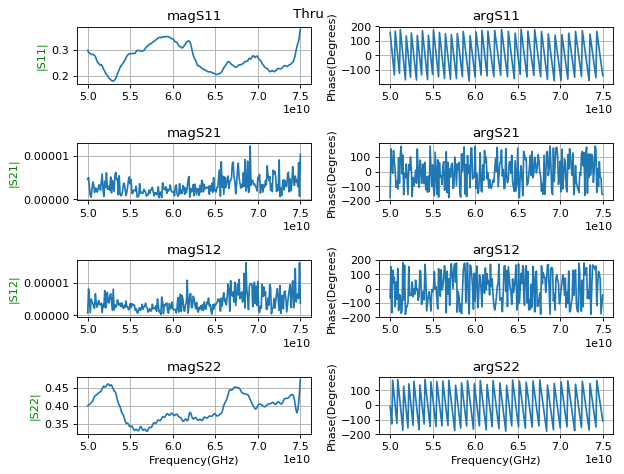

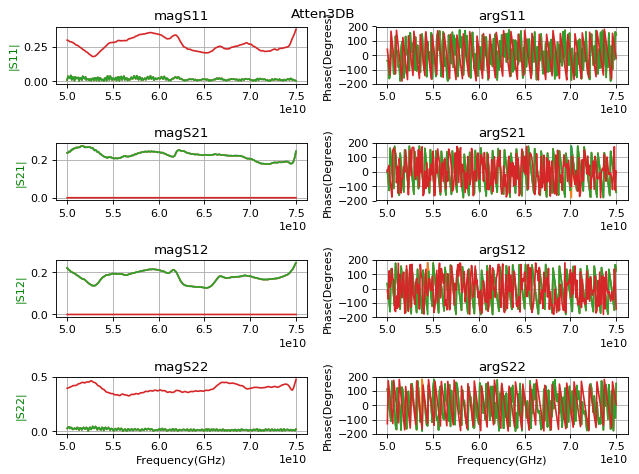

In [17]:
for device_key in list(set(predictions.tolist())):
    device_list=[]
    for index,prediction in enumerate(predictions.tolist()):
        if prediction==device_key:
            device_list.append(test_file_s2p_list[index])

    title=device_type_dictionary[device_key]
    compare_s2p_plots(device_list,display_legend=False,title=title,format="MA");

In [84]:
def negative_training_set(mean_list,standard_deviation_list,expansion_factor=2.0,number_training_sets=1000):
    """Creates a negative training set """
    training_array=[]
    for i in range(number_training_sets):
        training_list_row=[]
        for index,mean_number in enumerate(mean_list):
            random_number=np.random.uniform(-1,1,1)
            while((mean_number-expansion_factor*standard_deviation_list[index])<=random_number<=(mean_number+expansion_factor*standard_deviation_list[index])):
                random_number=np.random.uniform(-1,1,1)
            training_list_row.append(random_number.tolist()[0])
        training_array.append(np.array(training_list_row))
    return training_array
        

In [85]:
pretrain_folder=r"C:\Share\WaveParameter Machine Learning\PretrainByDeviceType\Atten3DB\s2p"
pretrain_files=os.listdir(pretrain_folder)
pretrain_files=map(lambda x:os.path.join(pretrain_folder,x),pretrain_files)
# now open the files convert them to AsciiData Tables and find the mean and standard deviation
first_file=Snp_to_AsciiDataTable(SNP(pretrain_files[0]))
joined_file=first_file.copy()
for file_name in pretrain_files[1:]:
    joined_file=joined_file+Snp_to_AsciiDataTable(SNP(file_name))
mean_file=frequency_model_collapse_multiple_measurements(joined_file)
std_file=frequency_model_collapse_multiple_measurements(joined_file,method="std")
mean_array=AsciiDataTable_to_NumpyArray(mean_file,exclude_columns="Frequency")
std_array=AsciiDataTable_to_NumpyArray(std_file,exclude_columns="Frequency")
test_list=negative_training_set(mean_array,std_array,1000.)

In [64]:
len(test_list[0])

2008

In [79]:

for item in test_list[0:10]:
    plt.plot(range(len(item)),item,'x')
plt.fill_between(range(len(mean_array)),mean_array-1000.*std_array,mean_array+1000*std_array,label="Mean",edgecolor=(0, .0, .0, .25),
                        facecolor=(.25, .25, .25, .25),
                        linewidth=1)

plt.legend()
plt.show()

In [50]:
mean_array-std_array

array([ 0.00680182,  0.02520734, -0.0276932 , ...,  0.01120757,
       -0.00601399,  0.00958216])

In [67]:
plt.close()

In [91]:
single_point=[test_list[i][1000] for i in range(len(test_list))]

In [92]:
plt.hist(single_point,bins=200)
plt.show()

In [ ]:
plt.plot(mean_arr)

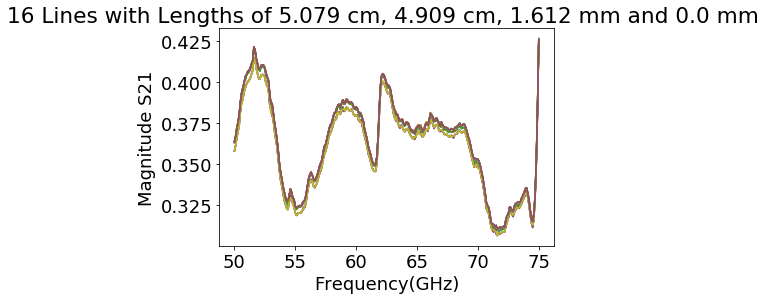

In [28]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})
# Now I want a plot of the S21 of all of the Lines to show that they are hard to tell apart
num_files=0
for test_file in test_file_s2p_list[:]:
    if re.search("Line|Thru",test_file.path,re.IGNORECASE):
        num_files+=1
        test_file.change_data_format("MA")
        plot_name=os.path.split(test_file.path)[-1]
        plt.plot(10**-9*np.array(test_file["Frequency"]),test_file["magS21"],label=plot_name)
plt.xlabel("Frequency(GHz)")
plt.ylabel("Magnitude S21")
plt.title("{0} Lines with Lengths of 5.079 cm, 4.909 cm, 1.612 mm and 0.0 mm ".format(num_files))
#plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.show()

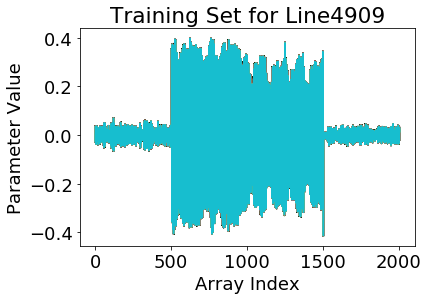

In [36]:
set_number=4
for i in range(number_training_sets):
    plt.plot(training_array[i+set_number*number_training_sets])
plt.ylabel("Parameter Value")
plt.xlabel("Array Index")
plt.title("Training Set for {0}".format(device_type_dictionary[sorted_device_keys[set_number]]))
plt.show()

## Calibration Training

In [39]:
comparison_correction_list=[]
dates=["20160822","20160824","20160825",
      "20160826","20160914","20160915",
      "20160916","20160919","20160920",
      "20160921","20160923","20160926"]
cal_names=["cal1","cal2"]
for date in dates:
    cal_list=[]
    for cal in cal_names:
        correction=SNP(r"C:\Users\sandersa\OneDrive - National Institute of Standards and Technology (NIST)\Papers\Calibration Comparison Overtime\VNA_OSLT_TypeN_Room1207_2016\{0}\{1}\OSLTMenuTypeN_vnauncert_Results\Solutions\Solution_0.s4p".format(date,cal))
        cal_list.append(correction)
    comparison_correction_list.append(cal_list)

In [42]:
# Now use a few of them to calculate the standard deviation and the mean
first_cal=Snp_to_AsciiDataTable(comparison_correction_list[0][0])

In [41]:
comparison_correction_list[0]

[<Code.DataHandlers.TouchstoneModels.SNP instance at 0x000000004284C288>,
 <Code.DataHandlers.TouchstoneModels.SNP instance at 0x000000003D0FCC88>]

In [45]:
first_cal["Frequency"]

[3.3,
 3.30002442748,
 3.30004885496,
 3.30007328244,
 3.30009770992,
 3.3001221374,
 3.30014656489,
 3.30017099237,
 3.30019541985,
 3.30021984733,
 3.30024427481,
 3.30026870229,
 3.30029312977,
 3.30031755725,
 3.30034198473,
 3.30036641221,
 3.30039083969,
 3.30041526718,
 3.30043969466,
 3.30046412214,
 3.30048854962,
 3.3005129771,
 3.30053740458,
 3.30056183206,
 3.30058625954,
 3.30061068702,
 3.3006351145,
 3.30065954198,
 3.30068396947,
 3.30070839695,
 3.30073282443,
 3.30075725191,
 3.30078167939,
 3.30080610687,
 3.30083053435,
 3.30085496183,
 3.30087938931,
 3.30090381679,
 3.30092824427,
 3.30095267176,
 3.30097709924,
 3.30100152672,
 3.3010259542,
 3.30105038168,
 3.30107480916,
 3.30109923664,
 3.30112366412,
 3.3011480916,
 3.30117251908,
 3.30119694656,
 3.30122137405,
 3.30124580153,
 3.30127022901,
 3.30129465649,
 3.30131908397,
 3.30134351145,
 3.30136793893,
 3.30139236641,
 3.30141679389,
 3.30144122137,
 3.30146564885,
 3.30149007634,
 3.30151450382,
 3.3015

In [2]:
two_port=pandas.read_csv(r"C:\Share\Converted_Check_Standard\Combined_Two_Port_Check_Standard.csv")

C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10,11,12,16,18,19,20,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
two_port.columns

Index([u'Frequency', u'Direction', u'Connect', u'magS11', u'argS11', u'magS21',
       u'argS21', u'magS22', u'argS22', u'System_Id', u'System_Letter',
       u'Connector_Type_Calibration', u'Connector_Type_Measurement',
       u'Measurement_Type', u'Measurement_Date', u'Measurement_Time',
       u'Program_Used', u'Program_Revision', u'Operator', u'Calibration_Name',
       u'Calibration_Date', u'Port_Used', u'Number_Connects',
       u'Number_Repeats', u'Nbs', u'Number_Frequencies', u'Start_Frequency',
       u'Device_Description', u'Device_Id', u'Measurement_Timestamp'],
      dtype='object')

In [4]:
device_ids=two_port["Device_Id"].unique()

In [5]:
device_ids

array(['C00001', 'C07202', 'C07203', 'C07205', 'C07206', 'C07106',
       'C07207', 'C07208', 'C07209', 'C14202', 'C14205', 'C14206',
       '000000', 'C22201', 'C22202', 'C22203', 'C24201', 'C24202',
       'C24203', 'C24204', 'C24205', 'C24206', 'C24207', 'C25202',
       'C28201', 'C28202', 'C29201', 'C29202', 'C35202', 'C35203',
       'C35204', 'C35205', 'C35207', 'C35209', 'C35210', 'C42202',
       'C62201', 'C62202', 'C90200', 'C90201', 'C90202', 'CBS00A',
       'CBS00B', 'CBS00C', 'CBS00D', 'CIS00A', 'CIS00B', 'CIS00C',
       'CIS00D', 'CIS00E', 'CRD209', 'CRD210', 'CRD211', 'CRD212',
       'CTN108', 'CTN201', 'CTN203', 'CTN206', 'CTN208', 'CTN209',
       'CTN210', 'CTN212', 'CTN213', 'CTM213', 'CTN214', 'CTN216',
       'CTN217', 'C07201', 'C10201', 'C10202', 'C10203', 'C14201',
       'C14203', 'C14204', 'C15202', 'C15203', 'C15206', 'C25203',
       'C42201', 'CTN202', 'CTN205'], dtype=object)

In [64]:
C24201=two_port[two_port["Device_Id"]=="C24202"]

In [85]:
for column in C24201.columns:
    if len(C24201[column].unique())==1:
        print(column+" is "+ str(C24201[column].unique()))

System_Id is ['HP8510']
Connector_Type_Calibration is [nan]
Connector_Type_Measurement is [2.4]
Measurement_Type is ['2-port']
Calibration_Name is [nan]
Device_Id is ['C24202']


In [6]:
training_metadata_dictionary={}
device_history_dictionary={}
for device_id in device_ids[:]:
    device_history=two_port[two_port["Device_Id"]==device_id]
    device_history_dictionary[device_id]=device_history
    unique_metadata_keys=[]
    for column in device_history.columns:
        if len(device_history[column].unique())==1:
            unique_metadata_keys.append(column)
    training_metadata_dictionary[device_id]={key:device_history[key].unique() for key in unique_metadata_keys}

In [148]:
np.mean(device_history_dictionary['C00001'][["Frequency","magS11","argS11","magS21","argS21","magS22","argS22"]][0:3])
np.std(device_history_dictionary['C00001'][["Frequency","magS11","argS11","magS21","argS21","magS22","argS22"]][0:3])

Frequency    6.938894e-18
magS11       4.714045e-05
argS11       8.431291e-01
magS21       2.624669e-04
argS21       8.164966e-03
magS22       1.247219e-04
argS22       6.196165e+00
dtype: float64

In [7]:
from pyMez.Code.Analysis.SParameter import *
from pyMez.Code.DataHandlers.Translations import *

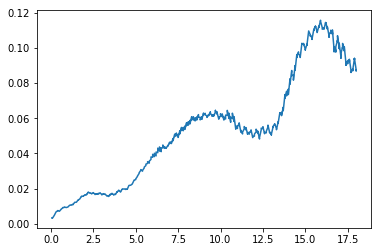

In [101]:
plt.plot(device_history_dictionary['C00001']["Frequency"],device_history_dictionary['C00001']["magS11"])

In [149]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])
clf = QuadraticDiscriminantAnalysis()
clf.fit(X, y)

X2 = np.array([[-4, -4], [-8, -4], [-12, -24], [4, 4], [8, 4], [12, 8]])
y2 = np.array([4, 4, 4, 8, 8, 8])
clf.fit(X2, y2)


print(clf.predict([[-0.8, -1]]))

[8]


In [108]:
two_port["Device_Description"].unique()

array(['Calorimeter C', '20 db checkstd', '7MM 20 DB CHECKSTD',
       '20 DB ATTENUATOR CHECKSTD', '20 DB CK STD', '20 dB check',
       '20dB check', '20 db chk', '50 db check', '50 dB check',
       '10 cm beaded airline ck std', 'ck std airline',
       '10 cm beaded airline', '7mm CHECK STANDARD 10 cm AIRLINE',
       '10 cm airline', 'Airline ck std', 'CK STD AIRLINE',
       'ck std 10 cm airline', '10 cm airline ck std',
       '7MM 10 CM BEADED AIRLINE', '7MM 10 CM BEADED AIRLINE CHECKSTD',
       '10 CM AIRLINE CHECKSTD', '10 CM AIRLINE',
       '10 CM BEADED AIRLINE CHECKSTD', '10 CM BEADED AIR LINE CHECKSTD',
       '10 CM A.L. CHECKSTD', '10 CM A.L. CHK STD',
       '7MM transmission line- checkstd', '7MM AIRLINE CHECKSTD',
       '10 CM LINE ck std', '10 CM AIR LINE CK STD - MULTICAL',
       '10 CM CK STD', '10 CM CK STD AIRLINE', 'll 2port solt cal',
       '10 cm airline check', 'Beaded airline check',
       '10cm beaded airline', '10 cm beaded check', '10 CM CHECK',


In [110]:
test_files[1:4]

['C:\\Share\\WaveParameter Machine Learning\\TestByDeviceType\\Kit_Attenuator_3dB_WR15_20180313_001.s2p',
 'C:\\Share\\WaveParameter Machine Learning\\TestByDeviceType\\Kit_Attenuator_3dB_WR15_20180313_002.s2p',
 'C:\\Share\\WaveParameter Machine Learning\\TestByDeviceType\\Kit_Attenuator_3dB_WR15_20180313_003.s2p']

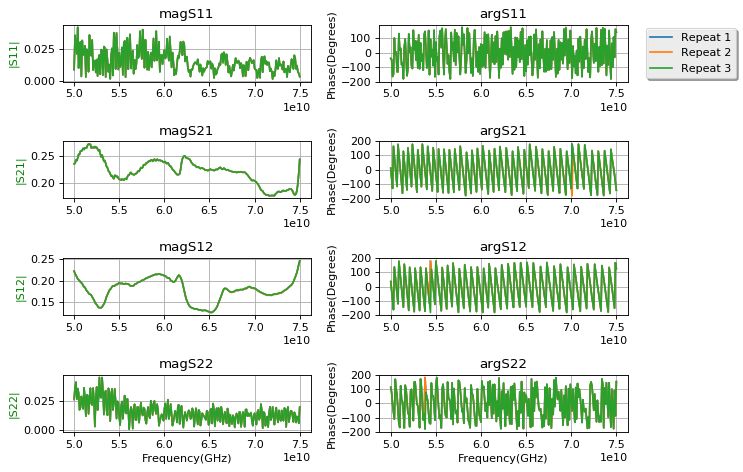

In [126]:
compare_s2p_plots(test_file_s2p_list[1:4],labels=["Repeat 1","Repeat 2","Repeat 3"],format="MA");

In [115]:
mean_3db=s2p_mean(test_file_s2p_list[1:4])

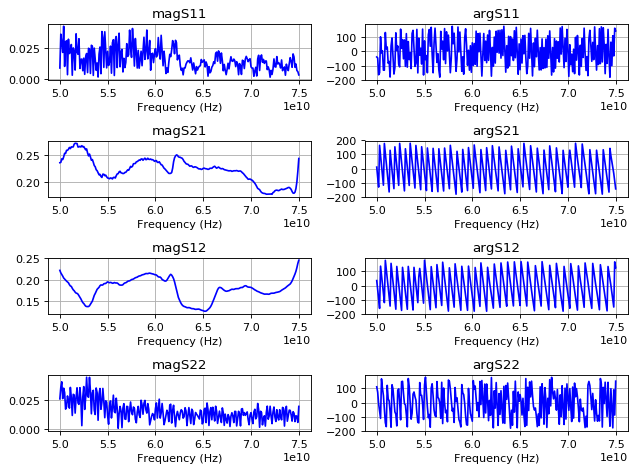

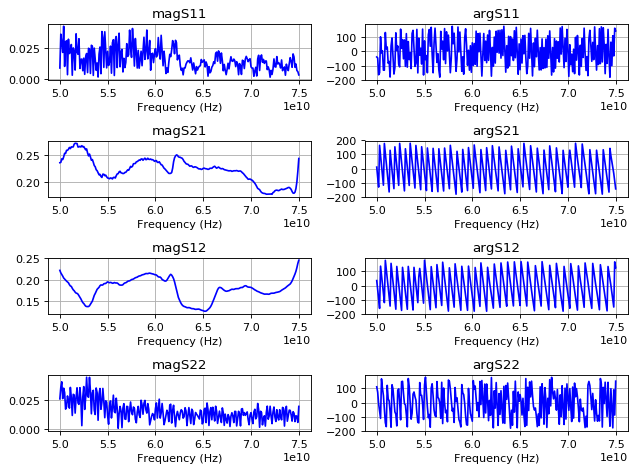

In [116]:
mean_3db.show()

In [119]:
diff_3db=s2p_difference(test_file_s2p_list[1],test_file_s2p_list[2])

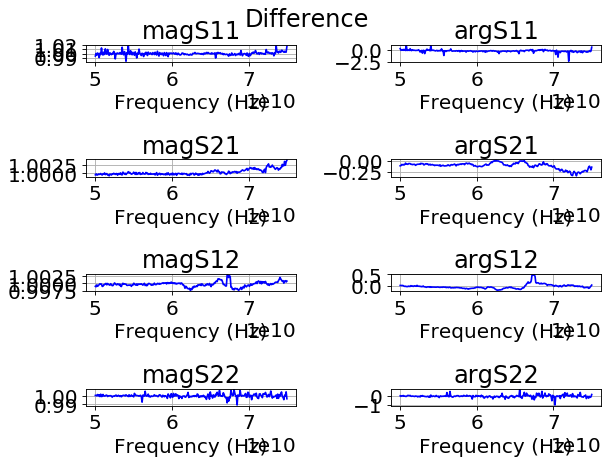

In [134]:
diff_3db.show(plot_title="Difference");

In [124]:
print(diff_3db["magS11"])

None


In [125]:
diff_3db.column_names

['Frequency',
 'dbS11',
 'argS11',
 'dbS21',
 'argS21',
 'dbS12',
 'argS12',
 'dbS22',
 'argS22']

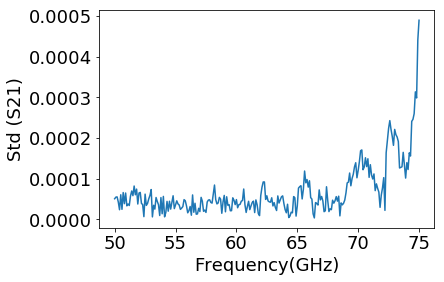

In [132]:
plt.rcParams.update({'font.size': 18})
plt.plot(10**-9*np.array(test_file_s2p_list[0]["Frequency"]),np.std(map(lambda x: x["magS21"],test_file_s2p_list[1:4]),axis=0))
plt.xlabel("Frequency(GHz)")
plt.ylabel("Std (S21)")
plt.show();

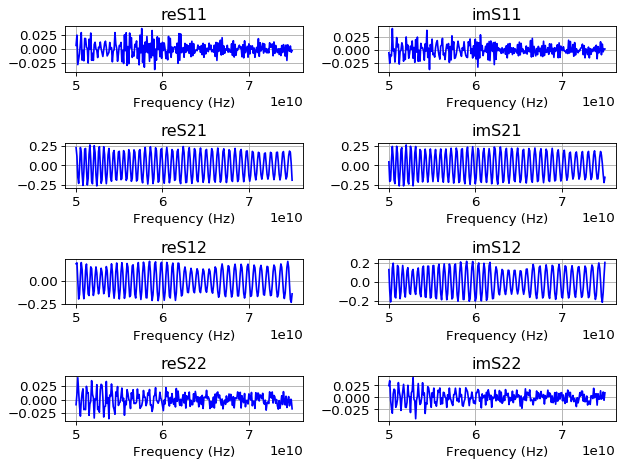

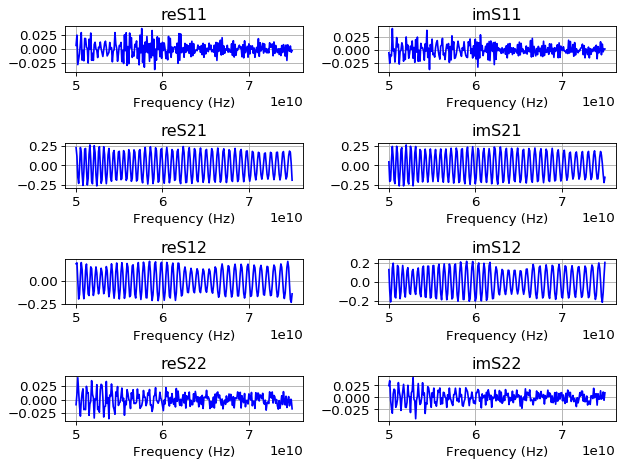

In [135]:
plt.rcParams.update({'font.size': 12})

test_file_s2p_list[1].show(format="RI")

In [136]:
noisy_s2p=add_white_noise_s2p(mean_3db)

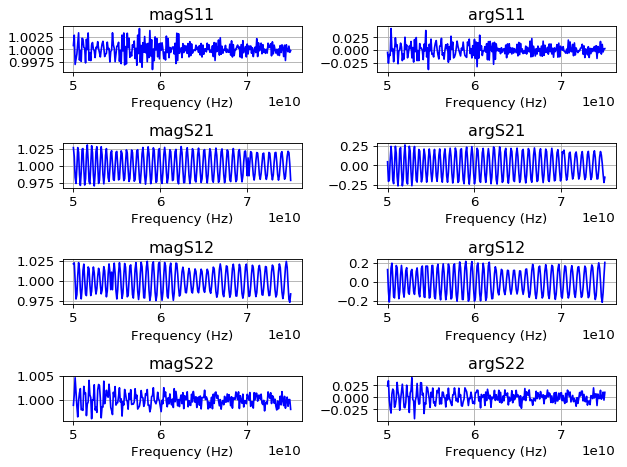

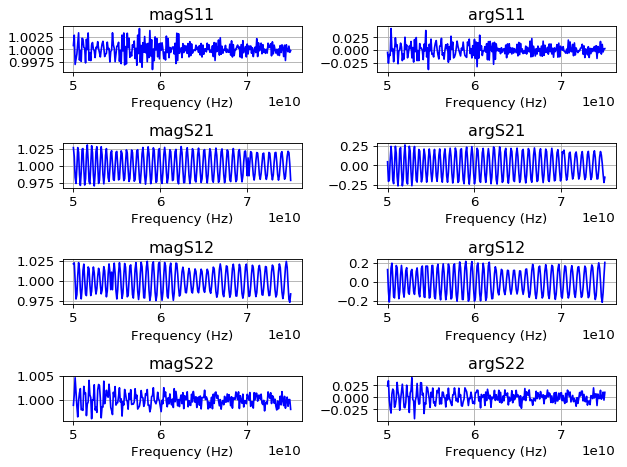

In [137]:
noisy_s2p.show()

In [138]:
diff=s2p_difference(noisy_s2p,mean_3db)

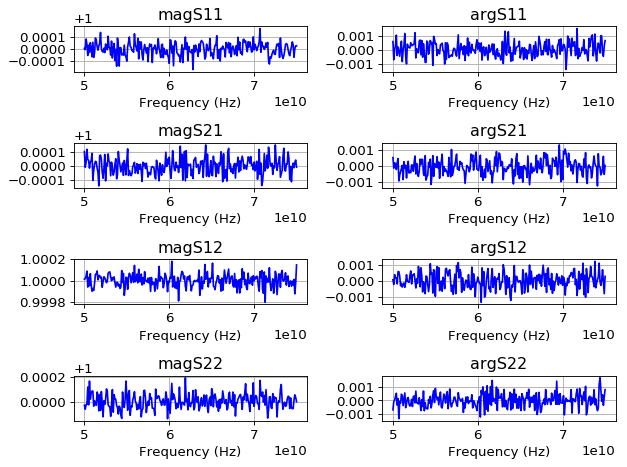

In [139]:
diff.show();

In [150]:
len(two_port)

454882

In [152]:
two_port.size

13646460

In [153]:
two_port[0:2]

,Frequency,Direction,Connect,magS11,argS11,magS21,argS21,magS22,argS22,System_Id,...,Calibration_Date,Port_Used,Number_Connects,Number_Repeats,Nbs,Number_Frequencies,Start_Frequency,Device_Description,Device_Id,Measurement_Timestamp
0,0.05,1.0,1,0.0033,0.40,0.9943,-6.45,0.0019,74.46,HP8510,...,NaN,2,3.0,1.0,4.0,181.0,7.0,Calorimeter C,C00001,2010-07-09 11:33:55
1,0.05,1.0,2,0.0033,-1.32,0.9938,-6.44,0.0021,85.57,HP8510,...,NaN,2,3.0,1.0,4.0,181.0,7.0,Calorimeter C,C00001,2010-07-09 11:33:55


In [162]:
sorted(device_history_dictionary.keys())

['000000',
 'C00001',
 'C07106',
 'C07201',
 'C07202',
 'C07203',
 'C07205',
 'C07206',
 'C07207',
 'C07208',
 'C07209',
 'C10201',
 'C10202',
 'C10203',
 'C14201',
 'C14202',
 'C14203',
 'C14204',
 'C14205',
 'C14206',
 'C15202',
 'C15203',
 'C15206',
 'C22201',
 'C22202',
 'C22203',
 'C24201',
 'C24202',
 'C24203',
 'C24204',
 'C24205',
 'C24206',
 'C24207',
 'C25202',
 'C25203',
 'C28201',
 'C28202',
 'C29201',
 'C29202',
 'C35202',
 'C35203',
 'C35204',
 'C35205',
 'C35207',
 'C35209',
 'C35210',
 'C42201',
 'C42202',
 'C62201',
 'C62202',
 'C90200',
 'C90201',
 'C90202',
 'CBS00A',
 'CBS00B',
 'CBS00C',
 'CBS00D',
 'CIS00A',
 'CIS00B',
 'CIS00C',
 'CIS00D',
 'CIS00E',
 'CRD209',
 'CRD210',
 'CRD211',
 'CRD212',
 'CTM213',
 'CTN108',
 'CTN201',
 'CTN202',
 'CTN203',
 'CTN205',
 'CTN206',
 'CTN208',
 'CTN209',
 'CTN210',
 'CTN212',
 'CTN213',
 'CTN214',
 'CTN216',
 'CTN217']

In [159]:
device_ids[0:4]

array(['C00001', 'C07202', 'C07203', 'C07205'], dtype=object)

In [224]:
device_history_dictionary["C07203"][0:2]

,Frequency,Direction,Connect,magS11,argS11,magS21,argS21,magS22,argS22,System_Id,...,Calibration_Date,Port_Used,Number_Connects,Number_Repeats,Nbs,Number_Frequencies,Start_Frequency,Device_Description,Device_Id,Measurement_Timestamp
6075,0.2,1.0,1,0.0122,168.56,0.0033,-15.66,0.017,-13.32,HP8510,...,NaN,1,3.0,1.0,4.0,90.0,7.0,50 db check,C07203,2003-07-18 14:54:59
6076,0.2,1.0,2,0.0122,168.66,0.0033,-15.76,0.017,-13.38,HP8510,...,NaN,1,3.0,1.0,4.0,90.0,7.0,50 db check,C07203,2003-07-18 14:54:59


In [13]:
# This is the bare training 
training_list=[]
target_list=[]
training_columns=["Frequency","magS11","argS11","magS21","argS21","magS22","argS22"]
for index,device_id in enumerate(device_ids[:]):
    device=device_history_dictionary[device_id][training_columns].values.tolist()
    for row_index,row in enumerate(device):
        training_list.append(row)
        target_list.append(index)
#training_array=np.array(training_list)
#target_array=np.array(target_list)

In [ ]:
two_port_classifier=DecisionTreeClassifier()
two_port_classifier.fit(training_list, target_list)

In [8]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import SVC
classifier_dict = {"QDA": QuadraticDiscriminantAnalysis,
                   "Gaussian Naive Bayes": GaussianNB,
                   "Bernoulli Naive Bayes": BernoulliNB,
                   "Multinomial Naive Bayes": MultinomialNB,
                   "Decision Tree": DecisionTreeClassifier,
                   "Random Forest": RandomForestClassifier,
                   "Ridge": RidgeClassifier,
                   "SGD": SGDClassifier,
                   "Passive Aggressive": PassiveAggressiveClassifier,
                   "Perceptron": Perceptron,
                   "SVC": SVC}

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
# Now train the classifier
classifier_keys=sorted(classifier_dict.keys())[10:11]
two_port_classifier_list=[]
two_port_prediction_list=[]
for key_index,key in enumerate(classifier_keys):
    two_port_classifier_list.append(classifier_dict[key]())
    try:
        two_port_classifier_list[key_index].fit(training_list, target_list)
        two_port_prediction_list.append(two_port_classifier_list[key_index].predict(training_list))
    except:
        raise
        print("{0} did not work".format(key))
for key_index,key in enumerate(classifier_keys):
    try:
        plt.close()
        plt.plot(target_list,two_port_prediction_list[key_index].tolist(),"rx")
        plt.xlabel("Device Trained")
        plt.ylabel("Device Predicted")
        plt.title(key)
        plt.show()
    except:pass

In [ ]:
key

In [239]:
predictions=two_port_classifier.predict(training_list)

In [226]:
named_predictions=map(lambda x: device_ids[x],predictions)

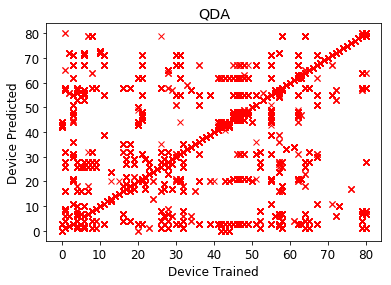

In [242]:
plt.plot(target_list,predictions.tolist(),"rx")
plt.xlabel("Device Trained")
plt.ylabel("Device Predicted")
plt.title("QDA")
plt.show()

In [ ]:
# This is the statistically similar training
training_list=[]
target_list=[]
training_columns=["Frequency","magS11","argS11","magS21","argS21","magS22"]
for index,device_id in enumerate(device_ids[0:10]):
    device_training_history=device_history_dictionary[device_id][training_columns]
    unique_frequency=device_training_history["Frequency"].unique()
    for 
    for row_index,row in enumerate(device):
        training_list.append(row)
        target_list.append(index)